In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

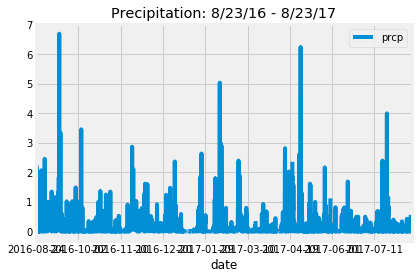

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest = (session.query(Measurement.date)
                    .order_by(Measurement.date.desc())
                    .first())
latest = list(np.ravel(latest))[0]
latest =dt.datetime.strptime(latest, '%Y-%m-%d')
# Calculate the date 1 year ago from the last data point in the database
latest_yr = int(dt.datetime.strftime(latest, '%Y'))
latest_mth = int(dt.datetime.strftime(latest, '%m'))
latest_day = int(dt.datetime.strftime(latest, '%d'))

yr_before = dt.date(latest_yr, latest_mth, latest_day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = (session.query(Measurement.date, Measurement.prcp)
                          .filter(Measurement.date > yr_before)
                          .order_by(Measurement.date)
                          .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_table = pd.DataFrame(precip_data)
precip_table = precip_table.set_index('date')

# Sort the dataframe by date
precip_table = precip_table.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_table.plot(title="Precipitation: 8/23/16 - 8/23/17")

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_table.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
st_ct = session.query(Station).count()
print(f"Station Count: {st_ct}")

Station Count: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
st_ct = (session.query(Measurement.station, func.count(Measurement.station))
                            .group_by(Measurement.station)
                            .order_by(func.count(Measurement.station).desc())
                            .all())
st_ct

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
st_id = st_ct[0][0]

st_nm = (session.query(Station.name)
                        .filter_by(station = st_id))
st_nm = st_nm[0][0]
print(f"The most active station is {st_id}: {st_nm}.")
# highest temperature recorded, and average temperature most active station?
l_temp = (session.query(Measurement.tobs)
                 .filter(Measurement.station == st_id)
                 .order_by(Measurement.tobs.asc())
                  .first())

l_temp = l_temp[0]
print(f"The lowest temperature recorded is {l_temp} degrees Farenheit.")

h_temp = (session.query(Measurement.tobs)
                         .filter(Measurement.station == st_id)
                         .order_by(Measurement.tobs.desc())
                         .first())

h_temp = h_temp[0]
print(f"The highest temperatire recorded is {h_temp} degrees Farenheit.")

avg_temp = (session.query(func.avg(Measurement.tobs))
                   .filter(Measurement.station == st_id))
avg_temp = '{0:.3}'.format(avg_temp[0][0])
print(f"The average temperature recorded is {avg_temp} degrees Farhenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US.
The lowest temperature recorded is 54.0 degrees Farenheit.
The highest temperatire recorded is 85.0 degrees Farenheit.
The average temperature recorded is 71.7 degrees Farhenheit.


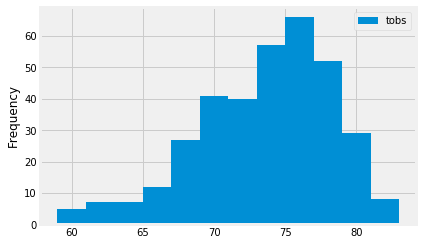

In [15]:
# Choose the station with the highest number of temperature observations.
temp_d = (session.query(Measurement.date, Measurement.tobs)
                      .filter(Measurement.date >yr_before)
                      .filter(Measurement.station == st_id)
                      .order_by(Measurement.date)
                      .all())
temp_table = pd.DataFrame(temp_d)
temp_table = temp_table.set_index('date')

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_table = temp_table.sort_index(ascending=True)
temp_table.plot(kind='hist', bins=12)

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
trip = '2019-05-05 to \n 2019-05-20'
trip_st_dt = '2017-05-05'
trip_end_dt = '2017-05-05'

# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps(trip_st_dt, trip_end_dt)

trip_temps

[(70.0, 76.33333333333333, 79.0)]

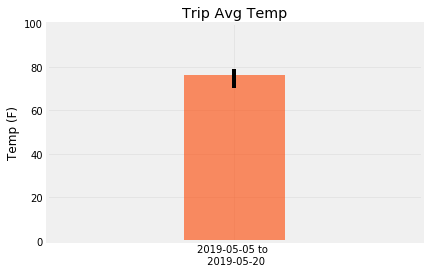

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_tp_temp = trip_temps[0][0]
avg_tp_temp = trip_temps[0][1]
max_tp_temp = trip_temps[0][2]

min_er = avg_tp_temp - min_tp_temp
max_er = max_tp_temp - avg_tp_temp

er_bars = np.array([[min_er], [max_er]])

plt.bar(trip, avg_tp_temp, yerr=er_bars, color = 'orangered', alpha = .6)
plt.ylim(0,100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station,
       Station.name,
       func.sum(Measurement.prcp),
       Station.latitude,
       Station.longitude,
       Station.elevation
       ])

st_rain = (session.query(*sel)
                    .filter(Station.station == Measurement.station)
                    .filter(Measurement.date >= trip_st_dt)
                    .filter(Measurement.date <= trip_end_dt)
                    .group_by(Station.station)
                    .order_by(func.sum(Measurement.prcp).desc())
                    .all())
st_rain_t = pd.DataFrame(np.array(st_rain))
st_rain_t = st_rain_t.rename(columns={0: "Station", 1: "Location", 
                                      2: "Total Precipitation", 3: "Latitude",
                                     4: "Longitude", 5: "Elevation"})

st_rain_t

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.28,21.5213,-157.8374,7.0
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.1,21.3331,-157.8025,152.4
2,USC00513117,"KANEOHE 838.1, HI US",0.0,21.4234,-157.8015,14.6
3,USC00519281,"WAIHEE 837.5, HI US",0.0,21.45167,-157.84888999999998,32.9
4,USC00519397,"WAIKIKI 717.2, HI US",0.0,21.2716,-157.8168,3.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.0,21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
